GET status: 200
PAGE 1 | skip=0 | status=200
PAGE 2 | skip=20 | status=200
PAGE 3 | skip=40 | status=200
PAGE 4 | skip=60 | status=200
PAGE 5 | skip=80 | status=200
PAGE 6 | skip=100 | status=200
PAGE 7 | skip=120 | status=200
PAGE 8 | skip=140 | status=200
PAGE 9 | skip=160 | status=200
PAGE 10 | skip=180 | status=200
PAGE 11 | skip=200 | status=200
PAGE 12 | skip=220 | status=200
PAGE 13 | skip=240 | status=200
PAGE 14 | skip=260 | status=200
PAGE 15 | skip=280 | status=200
PAGE 16 | skip=300 | status=200
GET status: 200
PAGE 1 | skip=0 | status=200
PAGE 2 | skip=20 | status=200
PAGE 3 | skip=40 | status=200
PAGE 4 | skip=60 | status=200
PAGE 5 | skip=80 | status=200
PAGE 6 | skip=100 | status=200
PAGE 7 | skip=120 | status=200
PAGE 8 | skip=140 | status=200
PAGE 9 | skip=160 | status=200
PAGE 10 | skip=180 | status=200
PAGE 11 | skip=200 | status=200
PAGE 12 | skip=220 | status=200
PAGE 13 | skip=240 | status=200
PAGE 14 | skip=260 | status=200
PAGE 15 | skip=280 | status=200
PAGE 1

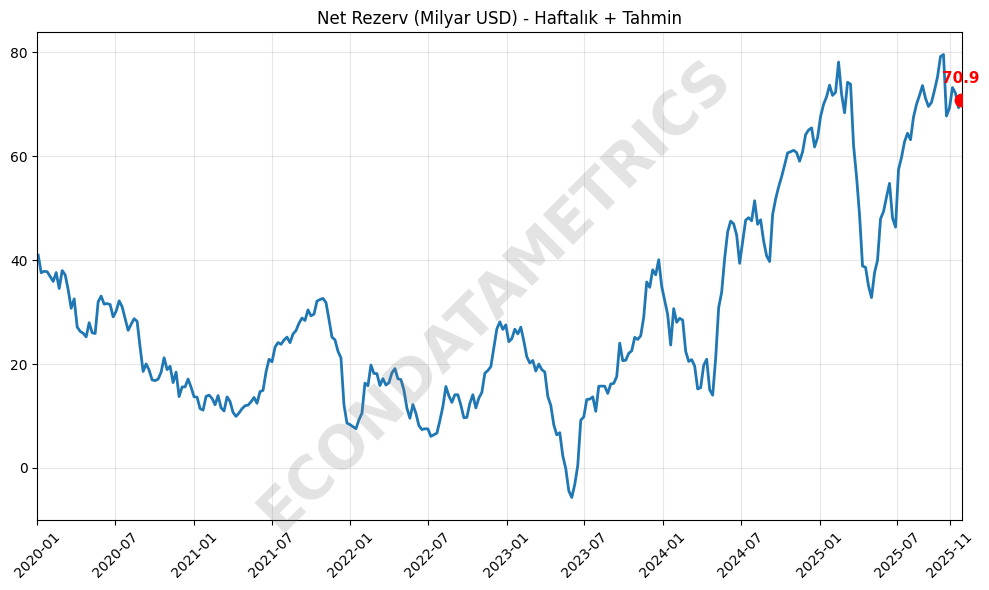

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from typing import Optional, Tuple

# =============================================================================
# Core EVDS Data Fetching Function
# =============================================================================

def evds_serie_market_all(
    series_code: str,
    start: str,
    end: str,
    datagroup: str = "",
    category: str = "",
    idx: int = 0,
    page_size: int = 20,
    aggregation_type: str = "last",
    frequency: str = "YEARWEEK",
    date_format_value: Optional[str] = None,
    verbose: bool = False,
    session: Optional[requests.Session] = None,
) -> pd.DataFrame:
    
    s = session or requests.Session()
    s.headers.update({
        "Accept": "*/*",
        "Accept-Language": "tr-TR,tr;q=0.9,en-US;q=0.8,en;q=0.7",
        "Accept-Encoding": "gzip, deflate",
        "Connection": "keep-alive",
        "User-Agent": "Mozilla/5.0",
        "X-Requested-With": "XMLHttpRequest",
        "Referer": "https://evds2.tcmb.gov.tr/index.php?/evds/serieMarket",
        "Origin": "https://evds2.tcmb.gov.tr",
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
    })

    # ---- İlk GET (session açılışı) try/except ----
    try:
        g = s.get("https://evds2.tcmb.gov.tr/index.php?/evds/serieMarket", timeout=30)
        if verbose:
            print("GET status:", g.status_code)
    except requests.RequestException as e:
        if verbose:
            print(f"GET isteğinde hata oluştu: {e}")
        return pd.DataFrame()

    select_code = f"{series_code}-{idx}"
    
    if date_format_value is None:
        date_format_value = "yyyy-ww"

    all_rows = []
    total_count = None
    skip = 0
    page_no = 1

    while True:
        payload = {
            "orderby": "Tarih desc",
            "thousand": 1,
            "decimal": 2,
            "sort": "Tarih#true",
            "frequency": frequency,
            "aggregationType": aggregation_type,
            "formula": 0,
            "graphicType": "0",
            "skip": skip,
            "take": page_size,
            "select": select_code,
            "startDate": start,
            "endDate": end,
            "categories": category,
            "mongoAdresses": "evds",
            "datagroupString": datagroup,
            "obsCountEnabled": "",
            "obsCount": "",
            "userId": "",
            "dateFormatValue": date_format_value,
            "customFormula": "null",
            "excludedSeries": "null",
        }

        # ---- POST try/except ----
        try:
            r = s.post("https://evds2.tcmb.gov.tr/EVDSServlet", data=payload, timeout=60)
            if verbose:
                print(f"PAGE {page_no} | skip={skip} | status={r.status_code}")
            r.raise_for_status()
        except requests.RequestException as e:
            if verbose:
                print(f"POST isteğinde hata oluştu (PAGE {page_no}, skip={skip}): {e}")
            break

        try:
            data = r.json()
        except ValueError:
            break

        if isinstance(data, list) and data:
            if total_count is None:
                total_count = data[0].get("totalCount", len(data))
            items_list = [row.get("items", {}) for row in data]
        elif isinstance(data, dict) and "items" in data:
            if total_count is None:
                total_count = data.get("totalCount", len(data["items"]))
            items_list = data["items"]
        else:
            items_list = []

        if not items_list:
            break

        all_rows.extend(items_list)
        got = len(items_list)
        skip += got
        page_no += 1

        if total_count is not None and len(all_rows) >= total_count:
            break

    if not all_rows:
        return pd.DataFrame()

    df = pd.DataFrame(all_rows)

    # Tarih kolonlarını parse et
    for col in df.columns:
        cl = col.lower()
        if cl.startswith("tar") or cl.startswith("date"):
            df[col] = pd.to_datetime(df[col], dayfirst=True, errors="coerce")

    # YEARWEEK varsa ve Tarih yoksa YEARWEEK -> Pazartesi tarihi
    if "YEARWEEK" in df.columns and "Tarih" not in df.columns:
        def yearweek_to_date(val):
            if pd.isna(val):
                return pd.NaT
            s = str(int(val))
            if len(s) < 6:
                s = s.zfill(6)
            year = int(s[:4])
            week = int(s[4:])
            try:
                # ISO week: Pazartesi
                return pd.to_datetime(f"{year}-W{week}-1", format="%G-W%V-%u")
            except Exception:
                return pd.NaT

        df["Tarih"] = df["YEARWEEK"].apply(yearweek_to_date)

    if "Tarih" in df.columns:
        df = df.sort_values("Tarih").reset_index(drop=True)

    return df

# =============================================================================
# Helper: Tek seriyi düzgün isimle çek (raise_if_empty opsiyonel)
# =============================================================================

def fetch_single_series(
    series_code: str,
    col_name: str,
    start: str,
    end: str,
    frequency: str,
    date_format_value: str,
    verbose: bool = False,
    session: Optional[requests.Session] = None,
    raise_if_empty: bool = True,
) -> pd.DataFrame:
    
    df = evds_serie_market_all(
        series_code=series_code,
        start=start,
        end=end,
        frequency=frequency,
        date_format_value=date_format_value,
        verbose=verbose,
        session=session,
    )

    if df.empty:
        if raise_if_empty:
            raise ValueError(f"{series_code} için veri gelmedi.")
        else:
            if verbose:
                print(f"UYARI: {series_code} için belirtilen aralıkta veri yok (boş DF).")
            out = pd.DataFrame(columns=[col_name])
            out.index = pd.DatetimeIndex([], name="Tarih")
            return out

    if "Tarih" not in df.columns:
        raise ValueError(f"{series_code} için 'Tarih' kolonu yok. Gelen kolonlar: {df.columns.tolist()}")

    non_value_cols = {"Tarih", "YEARWEEK", "UNIXTIME", "totalCount"}
    value_cols = [c for c in df.columns if c not in non_value_cols]

    if len(value_cols) != 1:
        raise ValueError(
            f"{series_code} için beklenenden farklı kolon yapısı: {df.columns.tolist()}"
        )

    val_col = value_cols[0]

    out = (
        df[["Tarih", val_col]]
        .rename(columns={val_col: col_name})
        .set_index("Tarih")
        .sort_index()
    )
    return out

# =============================================================================
# 1) WEEKLY OFFICIAL: N06 + USD KUR (YEARWEEK)
# =============================================================================

def fetch_weekly_official_from_evds(
    start: str = "01-01-2020",
    end: str = None,
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Resmi haftalık veri: N06 (rezerv TL) + USD/TL kuru (haftalık).
    Frekans: YEARWEEK
    """
    # end verilmemişse bugünün tarihini kullan
    if end is None:
        end = datetime.today().strftime("%d-%m-%Y")

    session = requests.Session()

    frequency = "YEARWEEK"
    date_format_value = "yyyy-ww"

    rezerv_tl = fetch_single_series(
        series_code="TP.AB.N06",
        col_name="rezerv_tl",
        start=start,
        end=end,
        frequency=frequency,
        date_format_value=date_format_value,
        verbose=verbose,
        session=session,
        raise_if_empty=True,
    )

    usdtry = fetch_single_series(
        series_code="TP.DK.USD.A.YTL",
        col_name="usdtry_weekly",
        start=start,
        end=end,
        frequency=frequency,
        date_format_value=date_format_value,
        verbose=verbose,
        session=session,
        raise_if_empty=True,
    )

    weekly = rezerv_tl.join(usdtry, how="inner")
    weekly["net_rezerv_usd_mn"] = weekly["rezerv_tl"] / weekly["usdtry_weekly"] / 1_000_000

    if verbose:
        print("WEEKLY DF (official):")
        print(weekly.tail())

    return weekly

# =============================================================================
# 2) DAILY ANALYTICAL BALANCE SHEET: FX + A02 + A14 (GÜNLÜK)
# =============================================================================

def fetch_daily_reserves_from_evds(
    start: str,
    end: str = None,
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Analitik bilançoya yönelik günlük veri:
      - USD/TL kuru (günlük)
      - A02: Dış varlıklar
      - A14: ZK yükümlülük
    """
    # end verilmemişse bugünün tarihini kullan
    if end is None:
        end = datetime.today().strftime("%d-%m-%Y")

    session = requests.Session()

    frequency = "WORKDAY"              
    date_format_value = "dd-MM-yyyy"

    usdtry_daily = fetch_single_series(
        series_code="TP.DK.USD.A.YTL",
        col_name="usdtry_daily",
        start=start,
        end=end,
        frequency=frequency,
        date_format_value=date_format_value,
        verbose=verbose,
        session=session,
        raise_if_empty=False,
    )

    dis_varlik = fetch_single_series(
        series_code="TP.AB.A02",
        col_name="dis_varlik",
        start=start,
        end=end,
        frequency=frequency,
        date_format_value=date_format_value,
        verbose=verbose,
        session=session,
        raise_if_empty=False,
    )

    # A11 şimdilik kullanılmıyor, istersen tekrar açarsın
    # doviz_dis_yukumluluk = fetch_single_series(
    #     series_code="TP.AB.A11",
    #     col_name="doviz_dis_yukumluluk",
    #     start=start,
    #     end=end,
    #     frequency=frequency,
    #     date_format_value=date_format_value,
    #     verbose=verbose,
    #     session=session,
    #     raise_if_empty=False,
    # )

    zk_yukumluluk = fetch_single_series(
        series_code="TP.AB.A14",
        col_name="zk_yukumluluk",
        start=start,
        end=end,
        frequency=frequency,
        date_format_value=date_format_value,
        verbose=verbose,
        session=session,
        raise_if_empty=False,
    )

    # ---- Boşluk kontrolü (A11'siz) ----
    if usdtry_daily.empty and dis_varlik.empty and zk_yukumluluk.empty:
        if verbose:
            print("UYARI: Günlük seriler için bu aralıkta hiç veri yok. daily_df boş döndü.")
        return pd.DataFrame()

    daily = (
        usdtry_daily
        .join(dis_varlik, how="outer")
        # .join(doviz_dis_yukumluluk, how="outer")
        .join(zk_yukumluluk, how="outer")
    )

    if verbose:
        print("DAILY DF (analytical-like):")
        print(daily.tail())

    return daily

# =============================================================================
# Haftalık net rezerv grafiği (son nokta tahmin olarak işaretli)
# =============================================================================

def add_diagonal_label(
    fig: plt.Figure,
    text: str = "ECONDATAMETRICS",
    color: str = "grey",
    alpha: float = 0.22,
    fontsize: int = 42,
    angle: float = 45,
):
    
    fig.text(
        0.5, 0.5,
        text,
        ha="center",
        va="center",
        rotation=angle,
        fontsize=fontsize,
        color=color,
        alpha=alpha,
        weight="bold",
    )

def plot_weekly_net_reserves_with_forecast(weekly_df: pd.DataFrame, figsize=(10,6)):

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(
        weekly_df.index,
        weekly_df["net_rezerv_usd_mn"],
        linewidth=2,
        label="Net rezerv (haftalık)"
    )

    last_date = weekly_df.index.max()
    last_value = float(weekly_df.loc[last_date, "net_rezerv_usd_mn"])

    ax.scatter([last_date], [last_value], color="red", s=80, zorder=10)

    # === NUMARAYI NOKTAYA YAZ ===
    ax.annotate(
        f"{last_value:,.1f}",
        xy=(last_date, last_value),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=11,
        fontweight="bold",
        color="red"
    )

    # --- X Ekseni ayarları ---
    min_date = weekly_df.index.min()
    max_date = weekly_df.index.max()
    first_month = pd.Timestamp(min_date.year, min_date.month, 1)
    last_month = pd.Timestamp(max_date.year, max_date.month, 1)

    ticks = pd.date_range(start=first_month, end=last_month, freq="6MS")
    if last_month not in ticks:
        ticks = ticks.append(pd.DatetimeIndex([last_month]))

    ax.set_xlim(first_month, last_month + pd.offsets.MonthEnd(0))
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    ax.set_title("Net Rezerv (Milyar USD) - Haftalık + Tahmin")
    add_diagonal_label(fig, text="ECONDATAMETRICS", color="grey", alpha=0.22)
    #ax.set_ylabel("Milyyar USD")
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig

# =============================================================================
# WEEKLY'YE GÜNLÜK DEĞİŞİMİ EKLEME FONKSİYONU
# =============================================================================

def append_daily_change_to_weekly(
    weekly_df: pd.DataFrame,
    daily_df: pd.DataFrame,
    change_col: str = "net_rezerv_change",
    target_col: str = "net_rezerv_usd_mn",
) -> pd.DataFrame:
    """
    daily_df'deki net_rezerv_change değerini kullanarak weekly_df'ye
    yeni bir tarih satırı ekler.

    new_date = daily_df.index[0]
    change   = daily_df[change_col].iloc[0]
    last_val = weekly_df[target_col].dropna().iloc[-1]
    new_val  = last_val + change
    """
    if daily_df.empty:
        raise ValueError("daily_df boş, eklenecek değişim yok.")

    if change_col not in daily_df.columns:
        raise KeyError(f"daily_df içinde '{change_col}' kolonu yok. Mevcut kolonlar: {daily_df.columns.tolist()}")

    if target_col not in weekly_df.columns:
        raise KeyError(f"weekly_df içinde '{target_col}' kolonu yok. Mevcut kolonlar: {weekly_df.columns.tolist()}")

    # 1) Günlük DF'den tarih ve değişim
    new_date = daily_df.index[0]
    change = float(daily_df[change_col].iloc[0])

    # 2) Weekly DF'den son DOLU net rezerv
    last_valid_mask = weekly_df[target_col].notna()
    if not last_valid_mask.any():
        raise ValueError(f"weekly_df['{target_col}'] kolonunda hiç dolu değer yok.")

    last_val = float(weekly_df.loc[last_valid_mask, target_col].iloc[-1])

    # 3) Yeni değer
    new_val = last_val + change

    # 4) Yeni satırı ekle (varsa overwrite)
    weekly_df.loc[new_date, target_col] = new_val

    # 5) Tarih sırasına göre sırala
    weekly_df = weekly_df.sort_index()

    return weekly_df

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    # 1) Haftalık resmi veri (N06 + haftalık kur), end = today (otomatik)
    weekly_df = fetch_weekly_official_from_evds(verbose=True).dropna()

    # Günlük veri için başlangıç:
    # net_rezerv_usd_mn kolonu BOŞ OLMAYAN son tarih
    if "net_rezerv_usd_mn" in weekly_df.columns:
        mask = weekly_df["net_rezerv_usd_mn"].notna()
        if mask.any():
            last_valid_date = weekly_df.index[mask].max()
        else:
            last_valid_date = weekly_df.index.max()
    else:
        last_valid_date = weekly_df.index.max()

    daily_start_str = last_valid_date.strftime("%d-%m-%Y")

    # 2) Günlük analitik veri (kur + A02 + A14), end = today (otomatik)
    daily_df = fetch_daily_reserves_from_evds(
        start=daily_start_str,
        end=None,          # None => today
        verbose=True,
    )

    print("\n=== WEEKLY DF (net reserves - BEFORE NOWCAST) ===")
    print(weekly_df.tail())

    print("\n=== DAILY DF (raw) ===")
    print(daily_df.head())

    # --- BURADAN SONRASI: GÜNLÜK NET REZERV DEĞİŞİMİ HESABI ---

    # Tüm seriler dolu olan gözlemleri al
    daily_df = daily_df.dropna()

    # En az 2 gözlem şartı (ilk/son fark için)
    if len(daily_df) < 2:
        raise ValueError("Günlük seriler için en az 2 gözlem gerekli (fark almak için).")

    # net rezerv (A02) / kur
    daily_df["dis_varlik_usd"] = (daily_df["dis_varlik"]) / daily_df["usdtry_daily"]
    # zorunlu karşılıkların USD karşılığı
    daily_df["zk_usd"] = daily_df["zk_yukumluluk"] / daily_df["usdtry_daily"]

    # Sadece ilk ve son tarihi al
    daily_df = daily_df.iloc[[0, -1]]
    # Fark al: son - ilk
    daily_df = daily_df.diff().dropna()

    # ZK düzeltmesi: net_rezerv_change - zk_usd
    daily_df["net_rezerv_change"] = daily_df["dis_varlik_usd"] - daily_df["zk_usd"]

    # Sadece ilgili kolonlar, milyon USD cinsinden
    daily_df = daily_df[["net_rezerv_change", "dis_varlik_usd", "zk_usd"]]
    daily_df = daily_df.div(1_000_000)

    print("\n=== DAILY DF (change) ===")
    print(daily_df)

    # --- WEEKLY'YE ŞİMDİ BU DEĞİŞİMİ EKLE ---
    weekly_df = append_daily_change_to_weekly(
        weekly_df=weekly_df,
        daily_df=daily_df,
        change_col="net_rezerv_change",
        target_col="net_rezerv_usd_mn",
    )[["net_rezerv_usd_mn"]]

    

    # Örnek: grafiği kaydetmek istersen
    fig = plot_weekly_net_reserves_with_forecast(weekly_df)
    fig.savefig("net_reserves_weekly.png", dpi=300, bbox_inches="tight")
    weekly_df.to_excel("net_rezervler.xlsx")
    plt.show()
